# Data Loader 
This cells in this file wil load each of the datasets and then save then as numpy arrays in the same folder that the og data was found in.  
  
Ideally this should be run once.

#### Imports

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

#### Data loader
Now anytime you want to grab the data run `np.load("path/to/file.npy")`

In [10]:
fiveFiftyPath = r"..\..\5_mr_50_cond\simulated_noNoise.txt"
fourtyFiftyPath = r"..\..\40_mr_50_cond\simulated_noNoise.txt"
hundidHundidPath = r"..\..\100_mr_100_cond\simulated_noNoise.txt"


data_5_mr_50_cond = np.loadtxt(fiveFiftyPath)
np.save(r"..\..\5_mr_50_cond\simulated_noNoiseAll", data_5_mr_50_cond)
data_5_mr_50_cond_tfs = data_5_mr_50_cond[1:,:100]
np.save(r"..\..\5_mr_50_cond\simulated_noNoiseTFs", data_5_mr_50_cond_tfs)
data_5_mr_50_cond_tgs = data_5_mr_50_cond[1:,100:200]
np.save(r"..\..\5_mr_50_cond\simulated_noNoiseTGs", data_5_mr_50_cond_tgs)

data_40_mr_50_cond = np.loadtxt(fourtyFiftyPath)
np.save(r"..\..\40_mr_50_cond\simulated_noNoiseAll", data_40_mr_50_cond)
data_40_mr_50_cond_tfs = data_40_mr_50_cond[1:,:100]
np.save(r"..\..\40_mr_50_cond\simulated_noNoiseTFs", data_40_mr_50_cond_tfs)
data_40_mr_50_cond_tgs = data_40_mr_50_cond[1:,100:200]
np.save(r"..\..\40_mr_50_cond\simulated_noNoiseTGs", data_40_mr_50_cond_tgs)

data_100_mr_100_cond = np.loadtxt(hundidHundidPath)
np.save(r"..\..\100_mr_100_cond\simulated_noNoiseAll", data_100_mr_100_cond)
data_100_mr_100_cond_tfs = data_100_mr_100_cond[1:,:100]
np.save(r"..\..\100_mr_100_cond\simulated_noNoiseTFs", data_100_mr_100_cond_tfs)
data_100_mr_100_cond_tgs = data_100_mr_100_cond[1:,100:200]
np.save(r"..\..\100_mr_100_cond\simulated_noNoiseTGs", data_100_mr_100_cond_tgs)



In [20]:

# Load ground truth
ground_truth_path_100mr_100cond = "../../100_mr_100_cond/bipartite_GRN.csv"
ground_truth = pd.read_csv(ground_truth_path_100mr_100cond, header=None).values



tf_100mr_normalized = np.zeros((100,100))
tg_100mr_nomralized = np.zeros((100,100))
scaler = MinMaxScaler((0,1))


for i in range(data_100_mr_100_cond_tfs.shape[1]):
    tf_100mr_normalized[:, i] = scaler.fit_transform(data_100_mr_100_cond_tfs[:,i].reshape(-1,1)).flatten()
    tg_100mr_nomralized[:, i] = scaler.fit_transform(data_100_mr_100_cond_tgs[:,i].reshape(-1,1)).flatten()


print("Normalized Target Genes and TFs for 100 MR")


Normalized Target Genes and TFs for 100 MR


#### Training

In [21]:
def train_random_forests(tf_expression, target_expression, n_estimators=100):
    """Train random forest models for each target gene.
    
    Args:
        tf_expression: Expression data for transcription factors
        target_expression: Expression data for target genes
        n_estimators: Number of trees in the random forest
        
    Returns:
        List of trained random forest models
    """
    models = []
    
    for i in range(target_expression.shape[1]):
        rf = RandomForestRegressor(n_estimators=n_estimators, bootstrap=True, max_samples=0.7, random_state=42)
        rf.fit(tf_expression, target_expression[:, i])
        models.append(rf)
        
    return models

# Train models
models_100mr = train_random_forests(tf_100mr_normalized, tg_100mr_nomralized)


In [ ]:
def get_feature_importance_matrix(models):
    """Extract feature importance scores for all models.
    
    Args:
        models: List of trained random forest models
        
    Returns:
        Matrix of feature importance scores
    """
    n_tfs = models[0].n_features_in_
    n_targets = len(models)
    
    importance_matrix = np.zeros((n_tfs, n_targets))
    
    for i, model in enumerate(models):
        importance_matrix[:, i] = model.feature_importances_
        
    return importance_matrix

# Get importance matrix
importance_matrix = get_feature_importance_matrix(models_100mr)
print(max(importance_matrix[:,i].flatten()) for i in range(100))


<generator object <genexpr> at 0x00000206A7C53BC0>


In [26]:
def reconstruct_network(importance_matrix, threshold):
    """Reconstruct network using importance threshold.
    
    Args:
        importance_matrix: Matrix of feature importance scores
        threshold: Threshold for considering a connection
        
    Returns:
        Binary adjacency matrix
    """
    return (importance_matrix > threshold).astype(int)

def create_adjacency_matrix(edge_list, n_tfs, n_targets):
    adj_matrix = np.zeros((n_tfs, n_targets))
    for tf, target in edge_list:
        adj_matrix[int(tf), int(target-100)] = 1
    return adj_matrix

def evaluate_network(predicted, ground_truth):
    """Calculate performance metrics.
    
    Args:
        predicted: Predicted network (binary matrix)
        ground_truth: Ground truth network (binary matrix)
        
    Returns:
        Dictionary of performance metrics
    """
    n_tfs, n_targets = predicted.shape
    ground_truth_matrix = create_adjacency_matrix(ground_truth, n_tfs, n_targets)
    
    # Calculate binary metrics
    precision = precision_score(ground_truth_matrix.flatten(), predicted.flatten())
    recall = recall_score(ground_truth_matrix.flatten(), predicted.flatten())
    f1 = f1_score(ground_truth_matrix.flatten(), predicted.flatten())
    
    # Calculate AUROC
    fpr, tpr, _ = roc_curve(ground_truth_matrix.flatten(), predicted.flatten())
    auroc = auc(fpr, tpr)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc,
        'fpr': fpr,
        'tpr': tpr
    }
# Try different thresholds
thresholds = np.linspace(0, 1, 100)
metrics_100mr = []


for threshold in thresholds:
    predicted_network = reconstruct_network(importance_matrix, threshold)
    metric = evaluate_network(predicted_network, ground_truth)
    metric['threshold'] = threshold
    metrics_100mr.append(metric)


metrics_df = pd.DataFrame(metrics_100mr)



c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

#### Plotting 

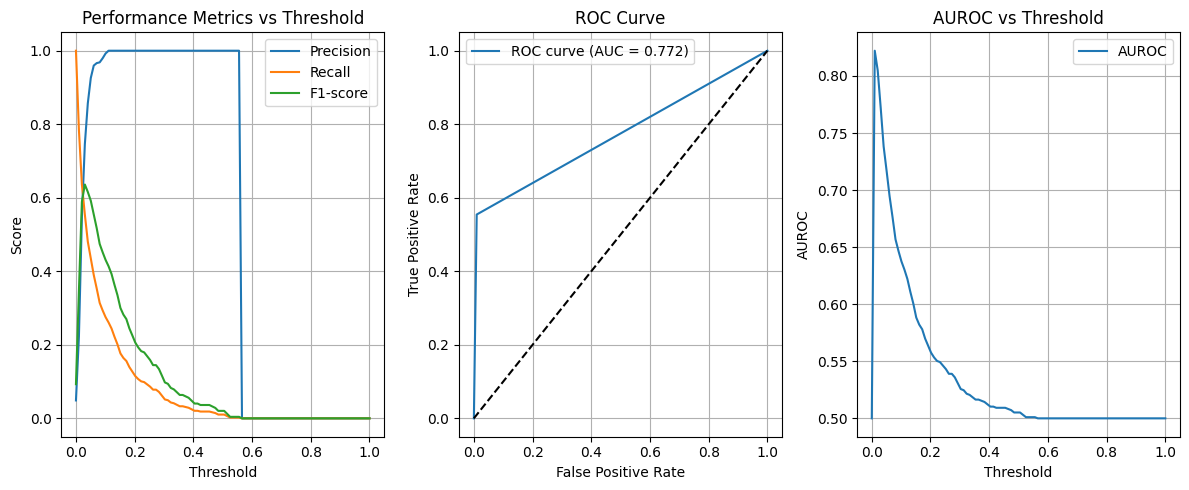

Best threshold: 0.030
Best F1-score: 0.636
AUROC: 0.772
Precision: 0.746
Recall: 0.554


In [27]:
# Plot performance metrics
plt.figure(figsize=(12, 5))

# Plot 1: Threshold-based metrics
plt.subplot(1, 3, 1)
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['f1'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Plot 2: ROC curve
plt.subplot(1, 3, 2)
best_idx = metrics_df['f1'].argmax()
best_metric = metrics_df.iloc[best_idx]
plt.plot(best_metric['fpr'], best_metric['tpr'], label=f'ROC curve (AUC = {best_metric["auroc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(metrics_df['threshold'], metrics_df['auroc'], label='AUROC')
plt.xlabel('Threshold')
plt.ylabel('AUROC')
plt.title('AUROC vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best metrics
print(f"Best threshold: {best_metric['threshold']:.3f}")
print(f"Best F1-score: {best_metric['f1']:.3f}")
print(f"AUROC: {best_metric['auroc']:.3f}")
print(f"Precision: {best_metric['precision']:.3f}")
print(f"Recall: {best_metric['recall']:.3f}")